# 생체인증보안 1871085 얼굴 2차 코드

In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
#tf.debugging.set_log_device_placement(True)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7585291383554439235
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10768720896
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14143101957398437383
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:09:00.0, compute capability: 6.1"
]


In [288]:
# 라이브러리 import
import PIL.Image as pilimg
import numpy as np
import glob
import matplotlib.pyplot as plt
import re

In [289]:
# 이미지 목록
images = glob.glob('./02_face_training/*.BMP')
len(images)

1050

In [290]:
r = re.compile('\d+')

img = [] # 이미지
label = [] # 라벨

for fname in images:
    l = r.findall(fname)[1]
    label.append(l)
    im = pilimg.open(fname)
    pix = np.array(im)/255. # Normalize
    img.append(pix)

In [291]:
X = np.array(img)
X = X.reshape(X.shape[0],56,46,1)
X.shape # img shape

(1050, 56, 46, 1)

In [292]:
y = np.array(label, dtype='int32')
y # label

array([132, 289, 283, ..., 144, 270, 260], dtype=int32)

In [293]:
X[0].shape

(56, 46, 1)

(56, 46, 1)
132


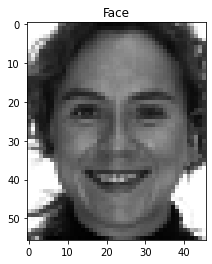

In [294]:
# 얼굴 이미지
plt.title('Face')
plt.imshow(X[0].reshape(56,46), cmap='gray')
print(X[0].shape)
print(y[0])

In [295]:
X.shape

(1050, 56, 46, 1)

## Data Augmentation

In [296]:
# !pip install imgaug

In [297]:
from imgaug import augmenters as iaa

In [298]:
seq = iaa.Sequential([
    # blur images with a sigma of 0 to 0.1
    iaa.GaussianBlur(sigma=(0, 0.05)),
    iaa.Affine(
        # scale images to 90-110% of their size, individually per axis
        #scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        # translate by -10 to +10 percent (per axis)
        translate_percent={"x": (-0.01, 0.01), "y": (-0.01, 0.01)},
        # rotate by -5 to +5 degrees
        #rotate=(-5, 5),
        # use nearest neighbour or bilinear interpolation (fast)
        order=[0, 1],
        # if mode is constant, use a cval between 0 and 255
        cval=0
    )
], random_order=True)

def aug_data(X_data, y_data):
    augmentated_data = [] # 생성한 이미지
    augmentated_label = [] # 생성한 이미지의 라벨
    for i in range(len(X)):
        augs = [X[i]] * 9 # 이미지당 9개 추가 생성
        augs = seq.augment_images(augs)
        for aug in augs:
            augmentated_data.append(aug)
            augmentated_label.append(y_data[i])
    
    return augmentated_data, augmentated_label

In [299]:
x_d, y_d = aug_data(X, y) # 이미지 생성

In [300]:
print(len(x_d), len(y_d))

9450 9450


(56, 46, 1)
132


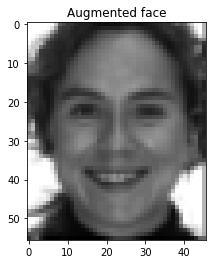

In [301]:
# 생성한 얼굴 이미지
plt.title('Augmented face')
plt.imshow(x_d[1].reshape(56,46), cmap='gray')
print(x_d[1].shape)
print(y_d[1])

In [302]:
# 생성한 이미지
x_d = np.array(x_d)
y_d = np.array(y_d)
print(x_d.shape)
print(y_d.shape)

(9450, 56, 46, 1)
(9450,)


In [303]:
# 기존 이미지
print(X.shape)
print(y.shape)

(1050, 56, 46, 1)
(1050,)


In [304]:
# 기존 이미지, 생성 이미지 합치기
X_data = np.concatenate([X, x_d], axis=0)
y_data = np.concatenate([y, y_d], axis=0)
print(X_data.shape)
print(y_data.shape)

(10500, 56, 46, 1)
(10500,)


# Data split

In [305]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data,y_data, test_size=0.2, shuffle=True, stratify=y_data, random_state=101)

In [306]:
X_train=X_train.astype('float32')
y_train=y_train.astype('int32')
X_test=X_test.astype('float32')
y_test=y_test.astype('int32')

In [307]:
X_train = X_train.reshape(X_train.shape[0],56,46,1)
X_test = X_test.reshape(X_test.shape[0],56,46,1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8400, 56, 46, 1) (8400,) (2100, 56, 46, 1) (2100,)


In [308]:
# Input shape
X_train[0].shape

(56, 46, 1)

In [309]:
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=351)
y_test = to_categorical(y_test, num_classes=351)

# Model

In [310]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Flatten, Dropout
from sklearn.model_selection import StratifiedKFold

In [311]:
# !pip install keras_vggface
# !pip install keras_applications

In [312]:
def build_model():
    learning_rate = 0.00001
    width = 56
    height = 46
    METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy')
    ]
    model = Sequential()
    model.add(Conv2D(filters=12, kernel_size=(3,3), padding='same', activation='selu', input_shape=(width,height,1)))
    model.add(Conv2D(filters=12, kernel_size=(3,3), padding='same', activation='selu'))
    model.add(Conv2D(filters=12, kernel_size=(3,3), padding='same', activation='selu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(256, activation='selu'))
    model.add(Dropout(0.1))
    model.add(Dense(32, activation='selu', kernel_regularizer='l2'))
    model.add(Dense(351, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = build_model()
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 56, 46, 12)        120       
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 56, 46, 12)        1308      
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 56, 46, 12)        1308      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 28, 23, 12)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 7728)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 256)               1978624   
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)             

In [313]:
# Cross validation
from sklearn.model_selection import KFold

kf = KFold(n_splits=4, shuffle=True, random_state=42)
all_history = [] # 결과 저장

def score_model(model, cv=None):
    if cv is None:
        cv = KFold(n_splits=4, random_state=42, shuffle=True)
        
    i=0
    for train_fold_index, val_fold_index in cv.split(X_train, y_train):
        i=i+1
        print('Fold #',i)
        # Get the training data
        X_train_fold, y_train_fold = X_train[train_fold_index], y_train[train_fold_index]
        # Get the validation data
        X_val_fold, y_val_fold = X_train[val_fold_index], y_train[val_fold_index]
        
        x,y,z,w = X_train_fold.shape

        print(X_val_fold.shape)
        print(y_val_fold.shape)
        
        # Fit the model
        model_obj = model.fit(X_train_fold, y_train_fold,
                              epochs=10,
                              validation_data=(X_val_fold, y_val_fold), 
                              verbose=1)
        all_history.append(model_obj.history)

# Example of the model in action
score_model(model, cv=kf)
model.save('./facemodel8.h5')

Fold # 1
(2100, 56, 46, 1)
(2100, 351)
Epoch 1/10
197/197 [==============================] - 8s 32ms/step - loss: 5.4220 - accuracy: 0.1425 - val_loss: 0.9338 - val_accuracy: 0.8710
Epoch 2/10
197/197 [==============================] - 1s 5ms/step - loss: 0.5918 - accuracy: 0.9501 - val_loss: 0.3325 - val_accuracy: 0.9933
Epoch 3/10
197/197 [==============================] - 1s 4ms/step - loss: 0.2919 - accuracy: 0.9960 - val_loss: 0.2096 - val_accuracy: 0.9971
Epoch 4/10
197/197 [==============================] - 1s 4ms/step - loss: 0.1868 - accuracy: 0.9991 - val_loss: 0.1494 - val_accuracy: 0.9976
Epoch 5/10
197/197 [==============================] - 1s 4ms/step - loss: 0.1367 - accuracy: 0.9967 - val_loss: 0.1542 - val_accuracy: 0.9871
Epoch 6/10
197/197 [==============================] - 1s 4ms/step - loss: 0.1559 - accuracy: 0.9871 - val_loss: 0.1198 - val_accuracy: 0.9948
Epoch 7/10
197/197 [==============================] - 1s 4ms/step - loss: 0.0999 - accuracy: 0.9984 - val_lo

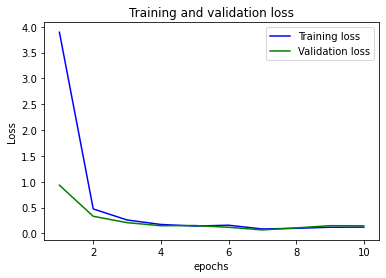

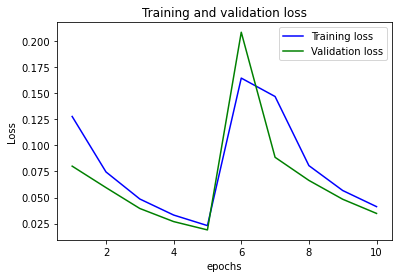

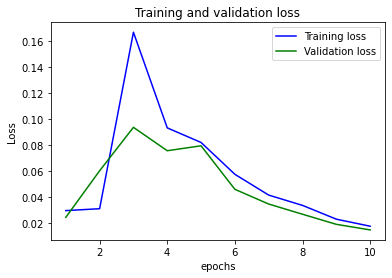

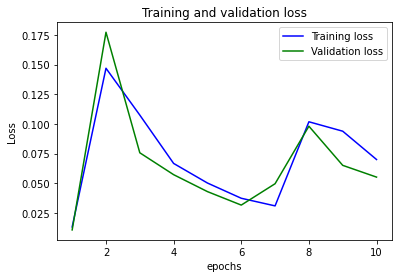

In [314]:
# Loss
for i in range(4):
    loss = all_history[i].get('loss') # train
    val_loss = all_history[i].get('val_loss') # val
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'b', label='Training loss')  # ‘b’는 파란색 실선을 의미합니다.
    plt.plot(epochs, val_loss, 'g', label='Validation loss') # ‘g’는 초록색 실선을 의미합니다.
    plt.title('Training and validation loss')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

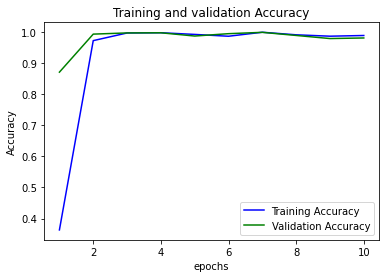

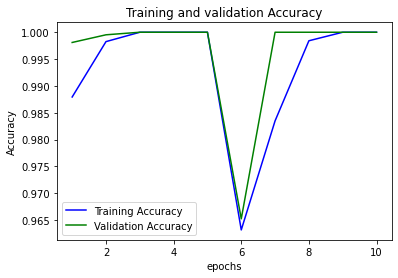

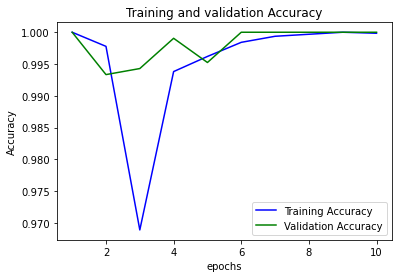

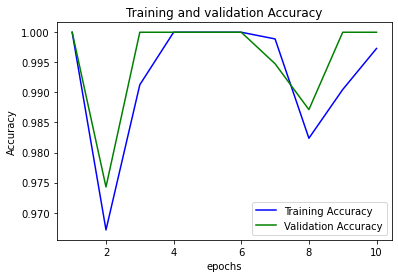

In [315]:
# Accuracy
for i in range(4):
    loss = all_history[i].get('accuracy') # train
    val_loss = all_history[i].get('val_accuracy') # val
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'b', label='Training Accuracy')  # ‘b’는 파란색 실선을 의미합니다.
    plt.plot(epochs, val_loss, 'g', label='Validation Accuracy') # ‘g’는 초록색 실선을 의미합니다.
    plt.title('Training and validation Accuracy')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [316]:
preds = np.argmax(model.predict(X_test), axis=1)
preds

array([ 53, 342, 172, ..., 339, 334,   1])

In [317]:
y_test_origin = np.argmax(y_test, axis=1)
y_test_origin

array([ 53, 342, 172, ..., 339, 334,   1])

(56, 46)
예측:  53
실제:  53


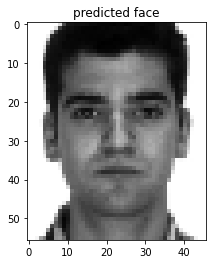

In [318]:
# 예측결과
plt.title('predicted face')
this_img = X_test[0].reshape(56,46)
plt.imshow(this_img, cmap='gray')
print(this_img.shape)
print('예측: ', preds[0])
print('실제: ', y_test_origin[0])
#X_test[0]

# Result

In [319]:
from sklearn.metrics import mean_squared_error
# rmse
rmse = np.sqrt(mean_squared_error(y_test_origin, preds)) 
print("RMSE: %f" % (rmse))

RMSE: 3.648679


In [320]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_origin,preds))

[[6 0 0 ... 0 0 0]
 [0 6 0 ... 0 0 0]
 [0 0 6 ... 0 0 0]
 ...
 [0 0 0 ... 6 0 0]
 [0 0 0 ... 0 6 0]
 [0 0 0 ... 0 0 6]]


In [321]:
from sklearn.metrics import classification_report
print(classification_report(y_test_origin,preds, zero_division=1))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         6
           7       1.00      1.00      1.00         6
           8       1.00      1.00      1.00         6
           9       1.00      1.00      1.00         6
          10       1.00      1.00      1.00         6
          11       1.00      1.00      1.00         6
          12       1.00      1.00      1.00         6
          13       1.00      1.00      1.00         6
          14       1.00      1.00      1.00         6
          15       1.00      1.00      1.00         6
          16       1.00      1.00      1.00         6
          17       1.00      1.00      1.00         6
          18       1.00    

## Test

In [322]:
images = glob.glob('./02_face_test/*.bmp')
len(images)

700

In [323]:
r = re.compile('\d+')

img = [] # 이미지
img_num = [] # 이미지 번호

for fname in images:
    num = r.findall(fname)[1]
    img_num.append(num)
    im = pilimg.open(fname)
    pix = np.array(im)/255. # Normalize
    img.append(pix)

(56, 46)
529


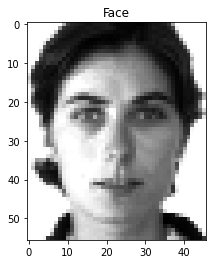

In [324]:
# 얼굴 이미지
plt.title('Face')
plt.imshow(img[0].reshape(56,46), cmap='gray')
print(img[0].shape)
print(img_num[0])

In [325]:
X = np.array(img)
X = X.astype('float32')
X = X.reshape(X.shape[0],56,46,1)

In [326]:
preds = np.argmax(model.predict(X), axis=1)
preds

array([ 80, 348, 232, 137, 168, 146, 138, 309, 329, 150,  52, 158,  84,
       326, 107,   5, 308,  54,  56,  68, 163, 335,  40,  32, 329, 290,
        82, 209, 270, 241, 261,  63, 225,  26, 109, 152, 325,  58, 117,
        80, 177, 271,  86, 312, 321,  80,  65,  76, 167,  19, 267, 185,
       239, 206,  92, 233,  33,  94, 242, 202,  72, 224, 214,  14,  53,
       231, 208, 289, 324, 194, 310, 271,  32,  83, 265, 340, 227, 287,
        46,  20,  52, 277, 268, 215, 323, 177, 186, 164, 297,  35,  76,
       127,  43, 125, 192,  96,  97, 150,  50, 197, 339, 113, 317,  56,
       214,  24, 256, 221, 108, 263, 309, 231, 101,  62, 109,  21, 258,
       288, 217,  72, 260, 183, 275,  60, 213, 168, 254, 102, 112, 231,
       136, 149, 266,   3, 269, 125,   3, 345,  28, 267,  23, 199, 180,
        59,  51,  37, 179, 185, 216, 191, 285, 192, 194, 225, 181, 297,
       254,  80, 279,  62,  22, 211, 184,   2, 277, 221, 131, 347, 293,
       193, 284, 345,  10, 227, 127, 201, 225, 312, 275,  73, 17

In [327]:
import pandas as pd
res_df = pd.DataFrame(img_num, columns=['Image'], dtype='int32')
res_df['Answer'] = pd.Series(preds, dtype='int32')
res_df.sort_values(by=['Image'], axis=0, inplace=True)
res_df

,Image,Answer
15,1,5
28,2,270
359,3,188
248,4,214
290,5,303
...,...,...
199,696,93
402,697,182
481,698,289
534,699,225


In [328]:
res_df['Answer'].value_counts()

225    11
239     9
231     9
80      8
221     7
       ..
142     1
140     1
134     1
126     1
349     1
Name: Answer, Length: 320, dtype: int64

In [329]:
res_df.to_csv('./1871085_얼굴_1차_답안v8.csv', index=False)